<a href="https://colab.research.google.com/github/Craftycripple/Who-is-my-favorite-actor-/blob/main/Favorite_actor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Выгружаем необходимые библиотеки
import requests
import zipfile
from pathlib import Path
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer
from typing import Dict, List

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision

## Предподготовка и выгрузка данных

In [2]:
# Устанавливаем нужные нам пути
data_path = Path('/content/')
train_path = data_path / 'train'

# Если нет папки для тренировочных данных
if train_path.is_dir():
    print(f'{train_path} directory exists.')
else:
    print(f'Did not find {train_path} directory, creating one...')

    # Выгружаем данные с репозитория
    with open(data_path / 'train.zip', 'wb') as f:
        request = requests.get('https://github.com/Craftycripple/Who-is-my-favorite-actor-/raw/main/train.zip')
        print('Downloading data...')
        f.write(request.content)

    # Распаковываем архив
    with zipfile.ZipFile(data_path / 'train.zip', 'r') as zip_ref:
        print('Unzipping data...')
        zip_ref.extractall(train_path)

/content/train directory exists.


In [3]:
data_path = Path('/content/')
test_path = data_path / 'test'

if test_path.is_dir():
    print(f'{test_path} directory exists.')
else:
    print(f'Did not find {test_path} directory, creating one...')

    with open(data_path / 'test.zip', 'wb') as f:
        request = requests.get('https://github.com/Craftycripple/Who-is-my-favorite-actor-/raw/main/test.zip')
        print('Downloading data...')
        f.write(request.content)

    with zipfile.ZipFile(data_path / 'test.zip', 'r') as zip_ref:
        print('Unzipping data...')
        zip_ref.extractall(test_path)

/content/test directory exists.


In [4]:
# Указываем путь к тренировочным и тестовым данным
train_dir = train_path / 'train'
test_dir = test_path / 'test'

## Создаем **transforms** для аугментации данных

In [5]:
# Создаем трансформер для тренировочных и тестовых данных

train_transforms = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Создаем трансформер для тестовых данных. Здесь мы просто изменяем размер картинки
test_transforms = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor()
])

In [6]:
# Создаем список с картинками из тренировочного набора
train_path_list = list(train_path.glob('*/*/*.jpg'))

In [7]:
# Создаем функцию для просмотра изображений
def plot_transformed_images(image_paths, transform, n=3):
    # Случайно выбираем фото из набора
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            # Показываем изначальный вариант
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Показываем преобразованный вариант
            # Используем функцию permute, так как здесь требуется другой формат представления тензора
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

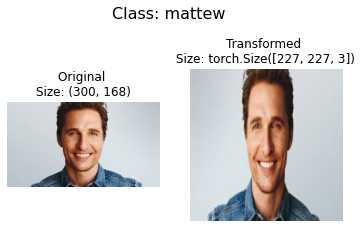

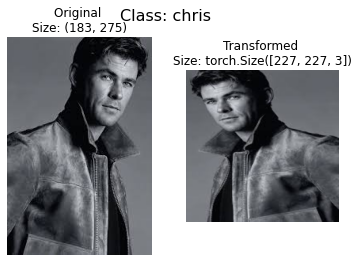

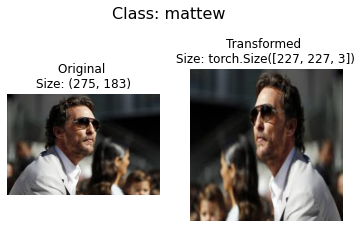

In [8]:
plot_transformed_images(train_path_list, 
                        transform=train_transforms,
                        n=3)

## Создание **datasets** и **DataLoader** для тренировочных и тестовых данных

In [9]:
# Создание переменных класса datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transforms,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transforms)

In [10]:
# Установим размер батча и количество ядер
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

In [11]:
# Создадим переменную класса DataLoader для тренировочного 
# и тестового набора, по которому в дальнейшем будем итерироваться для обучения модели
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f776c904fd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f77ea60eac0>)

In [12]:
# Так как Google Collab предоставляет GPU, будем использовать его
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
class_names = train_data.classes
class_names

['chris', 'james', 'mattew']

## Создание модели

In [13]:
# Создадим кастомную VGG подобную модель с BatchNorm слоями
class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        self.layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.layer_3 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        )
        self.layer_4 = nn.Sequential(
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.layer_5 = nn.Sequential(
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()
        )
        self.layer_6 = nn.Sequential(
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()
        )
        self.layer_7 = nn.Sequential(
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.layer_8 = nn.Sequential(
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        )
        self.layer_9 = nn.Sequential(
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        )
        self.layer_10 = nn.Sequential(
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.layer_11 = nn.Sequential(
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        )
        self.layer_12 = nn.Sequential(
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        )
        self.layer_13 = nn.Sequential(
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.fc_1 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=7*7*512,
                      out_features=4096),
            nn.ReLU()
        )
        self.fc_2 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096,
                      out_features=4096),
            nn.ReLU()
        )
        self.fc_3 = nn.Sequential(
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        out = self.layer_1(x)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        out = self.layer_5(out)
        out = self.layer_6(out)
        out = self.layer_7(out)
        out = self.layer_8(out)
        out = self.layer_9(out)
        out = self.layer_10(out)
        out = self.layer_11(out)
        out = self.layer_12(out)
        out = self.layer_13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc_1(out)
        out = self.fc_2(out)
        out = self.fc_3(out)
        return out

In [14]:
vgg_model = VGG16(num_classes = len(class_names)).to(DEVICE)

In [15]:
# Определим функцию потери и оптимизатор
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=vgg_model.parameters(),
                            lr=0.03)

In [16]:
# Создадим функцию для тренировочного этапа
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Переводим модель в режим обучения
    model.train()

    # Устанавливаем изначальные значения Accuracy
    train_loss, train_acc = 0, 0

    # Итерируемся по нашим данным
    for batch, (X, y) in enumerate(dataloader):
        # Переводим наши данные на GPU
        X, y = X.to(DEVICE), y.to(DEVICE)

        # 1. Прямое распространение
        y_pred = model(X)

        # 2. Считаем значения потери и Accuracy
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Обнуляем градиент
        optimizer.zero_grad()

        # 4. Обратное распространение
        loss.backward()

        # 5. Делаем шаг
        optimizer.step()

        # Считаем Accuracy по всем батчам
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Считаем средние значения метрики
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [17]:
# Создадим функцию для тестового этапа
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Переводим модель в режим оценки
    model.eval()

    # Устанавливаем изначальные значения функции потери и Accuracy
    test_loss, test_acc = 0, 0

    # Включаем контексный менеджер
    with torch.inference_mode():
        # Итерируемся по данным (шаги такие же, как и в предыдущей функции)
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(DEVICE), y.to(DEVICE)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [18]:
# Создаем объединенную функцию
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # Создаем словарь
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []
               }

    # Включаем цикл на заранее определенное количество эпох
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        
        print(
            f'Epoch: {epoch+1} | '
            f'Train Loss: {train_loss:.4f} | '
            f'Train Accuracy: {train_acc:.4f} | '
            f'Test Loss: {test_loss:.4f} | '
            f'Test Accuracy: {test_acc:.4f}' 
        )

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    return results        

## Обучаем модель

In [19]:
# Приступаем к обучению модели
torch.manual_seed(21)
torch.cuda.manual_seed(21)

# Устанавливаем количество эпох
NUM_EPOCHS = 300

# Устанавливаем таймер времени
start_time = timer()

# Тренируем нашу модель
vgg_model_results = train(model=vgg_model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f'Total training time: {end_time - start_time:.3f} seconds')

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 1.2831 | Train Accuracy: 0.3527 | Test Loss: 1.1298 | Test Accuracy: 0.3750
Epoch: 2 | Train Loss: 1.1299 | Train Accuracy: 0.3897 | Test Loss: 1.2161 | Test Accuracy: 0.3125
Epoch: 3 | Train Loss: 1.1526 | Train Accuracy: 0.3731 | Test Loss: 1.1294 | Test Accuracy: 0.3506
Epoch: 4 | Train Loss: 1.1077 | Train Accuracy: 0.3996 | Test Loss: 1.1942 | Test Accuracy: 0.2926
Epoch: 5 | Train Loss: 1.0682 | Train Accuracy: 0.4309 | Test Loss: 1.1026 | Test Accuracy: 0.4324
Epoch: 6 | Train Loss: 1.0709 | Train Accuracy: 0.4299 | Test Loss: 1.4105 | Test Accuracy: 0.3875
Epoch: 7 | Train Loss: 1.0755 | Train Accuracy: 0.4290 | Test Loss: 1.8878 | Test Accuracy: 0.3187
Epoch: 8 | Train Loss: 1.0617 | Train Accuracy: 0.4342 | Test Loss: 1.2425 | Test Accuracy: 0.3812
Epoch: 9 | Train Loss: 1.0359 | Train Accuracy: 0.4905 | Test Loss: 1.3366 | Test Accuracy: 0.3858
Epoch: 10 | Train Loss: 1.0357 | Train Accuracy: 0.4602 | Test Loss: 1.3367 | Test Accuracy: 0.3670
Epoch: 11

In [25]:
# Создадим функцию для отображения результатов в виде графика
def plot_loss_curves(results: Dict[str, List[float]]):
    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15,7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

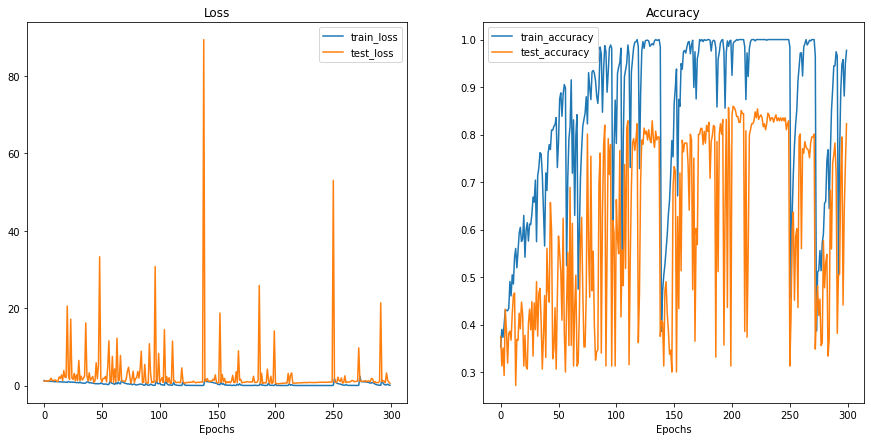

In [26]:
# Plot results
plot_loss_curves(vgg_model_results)

In [27]:
# Создадим новую переменную для имен класса чтобы имена и фамилии были заглавными
class_names_new = ['Chris Hemsworth', 'James McAvoy', 'Mattew McConaughey']

In [28]:
# Создадим функцию, которая будет принимать ссылку на фото и выдавать результат
def show_custom_image(url: str):
    custom_image_path = data_path / 'custom_image.jpeg'
    with open(custom_image_path, 'wb') as f:
        request = requests.get(url)
        f.write(request.content)

    custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
    custom_image = custom_image / 255.

    custom_image_transform = transforms.Compose([transforms.Resize((227, 227))])
    custom_image_transformed = custom_image_transform(custom_image)

    vgg_model.eval()
    with torch.inference_mode():
        custom_image_pred = vgg_model(custom_image_transformed.unsqueeze(dim=0).to(DEVICE))

    custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
    custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
    custom_image_pred_class = class_names_new[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
    probab = round(torch.max(custom_image_pred_probs.cpu()).numpy() * 100, 2)
    with Image.open(custom_image_path) as f:
        plt.imshow(f)
        plt.title(f'Это скорее всего {custom_image_pred_class} с вероятностью {probab}%')

## Сделаем предикт по одному фото для каждого класса

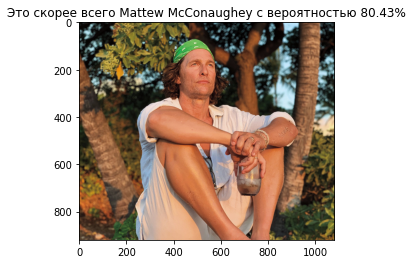

In [31]:
# Делаем предикт для Мэттью МакКонахи
show_custom_image('https://www.mensjournal.com/wp-content/uploads/2021/01/McConaughey4.jpg')

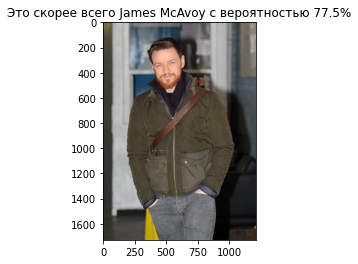

In [32]:
# Делаем предикт для Джеймса Макэвой
show_custom_image('https://i1.imageban.ru/out/2013/03/04/034ece661ee94b990000ec3875de6b03.jpg')

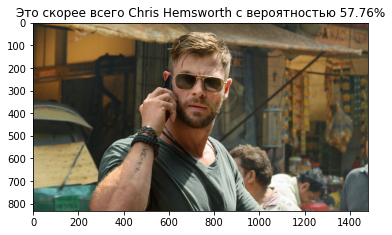

In [33]:
# Делаем предикт для Криса Хэмсворта
show_custom_image('https://kg-portal.ru/img/89696/main_2x.jpg')